In [1]:
import sys
import pickle
import matplotlib.pyplot as plt
import plotly.graph_objs
import plotly.offline
import plotly.figure_factory as ff

from pathlib import Path

from dotenv import find_dotenv, load_dotenv
# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
load_dotenv(find_dotenv())

PROJ_ROOT = Path('/home/jupyter/gama/bruno')

from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import wandb

import plotly.express as px
import plotly.graph_objects as go

import wandb

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler

from torchvision import models
from torch import nn

from sklearn.model_selection import KFold
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# wandb.login(relogin=True)

# Functions

In [3]:
def plot_residuals_sns(data):
    plt.figure(figsize=(8,8))
    sns.histplot(data=df_results,  x='PAD', linewidth=3, color='lightblue')
#     sns.swarmplot(data=df_results, y='PAD', color='.2',  edgecolor="white")

    plt.title('RESÍDUOS DE VALIDAÇÃO E TESTE', size=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('CONJUNTO DE DADOS', fontsize=18)
    plt.ylabel('RESÍDUOS', fontsize=18)
    return None

import plotly.express as px
import plotly.graph_objects as go

def plot_residuals_px(data):
    fig = go.Figure()
    for split_ in data.split.unique():
        fig.add_trace(go.Violin(x=data['split'][data['split'] == split_],
                            y=data['PAD'][data['split'] == split_],
                            name=split_,
                            box_visible=True,
                            meanline_visible=True,
                                points='outliers'))
    
    fig.show()
    return None

In [4]:
def wandb_victor(net: nn.Module, run_id: str, project='ADNI-testes'):
    best_model_file = wandb.restore(
        'model_best.pth',
#         'model_last.pth',
        run_path=f"victorhro/{project}/{run_id}",
        replace=True
    )
    net.load_state_dict(torch.load(best_model_file.name))

    return net

def wandb_gama(net: nn.Module, run_id: str,
                    project='ADNI-testes'):
    best_model_file = wandb.restore(
        'model_best.pth',
#         'model_last.pth',
        run_path=f"gama/{project}/{run_id}",
        replace=True
    )
    net.load_state_dict(torch.load(best_model_file.name))

    return net

In [5]:
def save_pred(y, y_pred, df, path: str, bias_fix=False):
    if bias_fix==False:
        np.save(path + 'y', y)
        np.save(path + 'y_pred', y_pred)
        df.to_csv(path + 'results.csv')
        return None
    if bias_fix==True:
        np.save(path + 'y_fix', y)
        np.save(path + 'y_pred_fix', y_pred)
        df.to_csv(path + 'results_fix.csv')
        return None

In [6]:
def fix_brats_bias(Y_pred):
    return Y_pred * brats_a + brats_b

In [7]:
def plot_scatter_dissertacao(df, baseline=False):
    df["age"] = df.age.astype(float)
    df["prediction"] = df.prediction.astype(float)
    fig = go.Figure()

    
    fig.add_trace(
        go.Scatter(x=df.age,
                   y=df.prediction,
                   mode='markers',
                   line=go.scatter.Line(color="blue"),
                   showlegend=True, name="Predicted age"))
    
    
    fig.update_layout(yaxis_range=[50,100])
    fig.update_layout(xaxis_range=[50,100])
    

    idx = df["age"].argsort().values
    y = df["age"].to_numpy()
    
    idx_pred = df['prediction'].argsort().values
    y_pred = df['prediction'].to_numpy()

        # recebe todas as idades nas posições originais do dataset
    
    fig.add_trace(
        go.Scatter(x=y[idx],
                   y=y[idx],
                   mode="lines",
                   line=go.scatter.Line(color="red"),
                   showlegend=True, name="Chronological age"))
    
    
    if baseline == True:
        a, b = np.polyfit(y_pred, y, 1)
        fig.add_trace(
            go.Scatter(x=[b, a * 100 + b],
                       y=[0, 100],
                       mode="lines",
                       line=go.scatter.Line(color="green"),
                       showlegend=True, name="Baseline"))
    
    
    
    fig.update_layout({"title": {"text": f'MAE: {df.iloc[0].MAE:.2f}',
                             "font": {"size": 20}}})
    fig.update_layout(font=dict(
                       size=20,
                       color="RebeccaPurple"),
                       xaxis_title='Age', yaxis_title='Predicted Age'
                     )
    
    fig.update_layout(width=800, height=600)
    fig.show()
    return None

In [8]:
def compute_scores(Y_pred, Y):
    image_MAE = np.abs(Y_pred - Y).mean()
    subject_Y_pred = Y_pred.mean(axis=-1)
    subject_MAE = np.abs(subject_Y_pred - Y[:,0]).mean()

    print(f"Per-image MAE   = {image_MAE:.4f}")
    print(f"Per-subject MAE = {subject_MAE:.4f} (mean agg)")
    print(f"Per-subject MAE = {np.abs(np.median(Y_pred, axis=-1) - Y[:,0]).mean():.4f} (median agg)")

def show_pred(subject_Y_pred, Y):
    mae = np.abs(subject_Y_pred - Y).mean()
    plt.suptitle(f'Per-subject predictions (MAE = {mae:.3f})')
    plt.scatter(Y, subject_Y_pred, s=3, marker='x', alpha=0.5)
    # plt.scatter(Y, subject_Y_pred - Y, s=3, marker='x', alpha=0.5)
    xlim = plt.xlim()
    ylim = plt.ylim()

    plt.plot([0.,100.],[0.,100.], 'r', label='ideal')

    a, b = np.polyfit(subject_Y_pred, Y, 1)
    plt.plot([b, a * 100 + b], [0, 100], label='best fit')

    plt.xlim([50, 100])
    plt.ylim([50, 100])

    plt.xlabel('True age')
    plt.ylabel('Predicted age')
    # plt.ylabel('Error')
    plt.gcf().set_size_inches((6,6))
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
def make_postprocessor(Y_pred, Y):  # expects Y_pred and Y at subject level
    from sklearn.linear_model import SGDRegressor
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler

    reg = make_pipeline(StandardScaler(), SGDRegressor(loss='epsilon_insensitive'))
    reg = reg.fit(Y_pred.reshape(-1,1), Y)

    return lambda y: reg.predict(y.reshape(-1,1))

import torch

def make_postprocessor_mlp(Y_pred, Y):  # expects Y_pred and Y at subject level
    model = torch.nn.Linear(1,1)
    optim = torch.optim.SGD(model.parameters(), lr=.1)

    loss_fun = torch.nn.L1Loss()

    X = (torch.from_numpy(Y_pred.reshape(-1,1)) - 50) / 50
    y = (torch.from_numpy(Y) - 50) / 50

    error = list()
    model.train()
    for epoch in range(1000):
        optim.zero_grad()

        y_pred = model(X).squeeze()

        loss = loss_fun(y_pred, y)

        loss.backward()
        optim.step()

        error.append(loss.item())
    
    model.eval()
    return lambda y: model((torch.from_numpy(y.reshape(-1,1)) - 50) / 50).squeeze().detach().numpy() * 50 + 50

In [10]:
from sklearn.metrics import mean_absolute_error
def predictions_dataframe(y_true: float, y_pred: float):

    # round using .:2f
    format_ = lambda x: "%.3f" % x
    #ae = np.abs(y_true - y_pred)
    ae = y_true - y_pred
    df = pd.DataFrame(
        {
            "age": y_true,
            "prediction": y_pred,
            "MAE": mean_absolute_error(y_true, y_pred),
            "PAD": ae,
        }
    )

    # aplying roundying
    df["prediction"] = df["prediction"].map(format_)
    df["PAD"] = df["PAD"].map(format_)
    return df

In [11]:
import h5py

from pathlib import Path

import torch

from torch.utils.data import Dataset
from torchvision import transforms


class ADNIDatasetForBraTSModel(Dataset):
    def __init__(
        self,
        hdf5_fpath,
        transform=torch.Tensor,
        dataset='train',
    ) -> None:
        super().__init__()

        hdf5_fpath = Path(hdf5_fpath)
        assert hdf5_fpath.exists()

        self._fpath = hdf5_fpath
        self.dataset = dataset

        self.transform = transform

    def __len__(self):
        with h5py.File(self._fpath, 'r') as h:
            if self.dataset == 'train+val':
                l = h['train']['y'].shape[0]
                l += h['val']['y'].shape[0]
            else:
                l = h[self.dataset]['y'].shape[0]

        return l

    def __getitem__(self, index: int):
        if self.dataset == 'train+val':
            with h5py.File(self._fpath, 'r') as h:
                train_len = h['train']['y'].shape[0]
            index_ = index - train_len

            if index_ < 0:
                dataset = 'train'
            else:
                dataset = 'val'
        else:
            index_ = index
            dataset = self.dataset

        with h5py.File(self._fpath, 'r') as h:
            img = h[dataset]['X'][index_]
            label = h[dataset]['y'][index_]

        # transform
        if self.transform is not None:
            img = self.transform(img)

        return img, label


In [13]:
def show_predictions(dataset, net):
    # predict
    dataloader = DataLoader(dataset, batch_size=40, shuffle=False)

    Y_pred = list()
    Y = list()
    
    try:
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)

            Y_pred.append(net(X.unsqueeze(1).repeat((1,3,1,1))).cpu().detach().numpy())
            Y.append(y.cpu().detach().numpy())

        Y = np.stack(Y)
        Y_pred = np.stack(Y_pred)[...,0]
        
    # only for unet model
    except RuntimeError:
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            
            # no need to repeat channels
            Y_pred.append(net(X.unsqueeze(1)).cpu().detach().numpy())
            Y.append(y.cpu().detach().numpy())

        Y = np.stack(Y)
        Y_pred = np.stack(Y_pred)


    # compute scores
    compute_scores(Y_pred, Y)

    # show_pred(Y_pred.mean(axis=-1), Y[:,0])
    print('std:', np.std(Y_pred))
    plot_scatter_dissertacao(predictions_dataframe(Y[:,0], np.median(Y_pred,axis=-1)), baseline=True)
    return Y, Y_pred

# Final Results

## EfficientNetB4

In [10]:
test_data = ADNIDatasetForBraTSModel('/home/jupyter/data/ADNI/brats_2mm_preprocessed/ADNI_slices_fix_2mm_split.hdf5', dataset='test')
len(test_data) / 40

NameError: name 'ADNIDatasetForBraTSModel' is not defined

In [14]:
net = models.efficientnet_b4(pretrained=True)
net.classifier  = nn.Sequential(
nn.Dropout(p=0.4, inplace=True),
nn.Linear(in_features=1792, out_features=1, bias=True))
net = wandb_victor(net, 'victorhro/ADNI-testes/29iu08u2').to(device)  # lr 1e-3 batch 64 MAE = 3.47

net.eval();

  0%|          | 0/584 [00:00<?, ?it/s]

Per-image MAE   = 3.9723
Per-subject MAE = 3.4747 (mean agg)
Per-subject MAE = 3.4800 (median agg)
std: 5.2135468


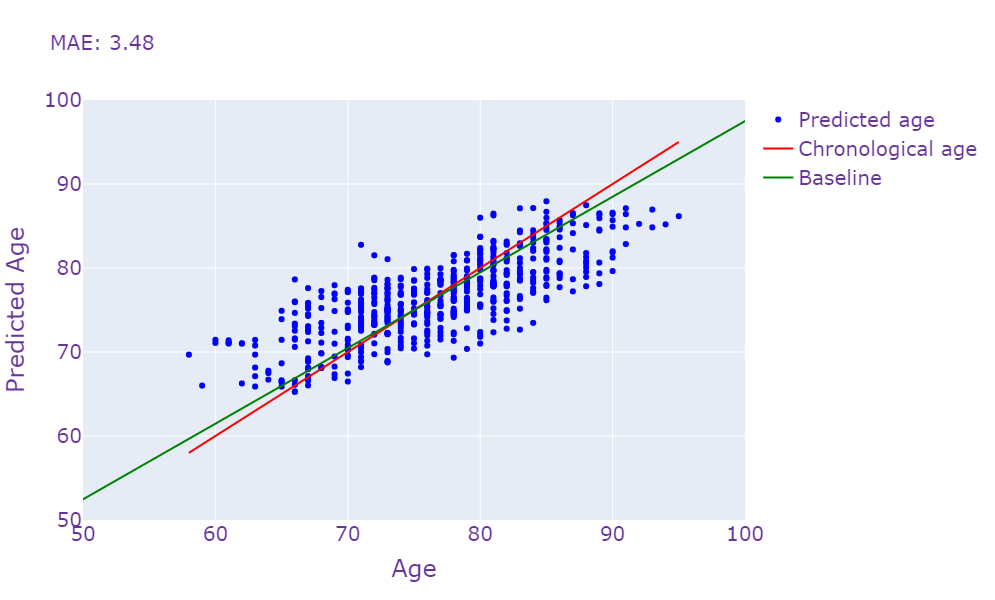

In [15]:
y, y_pred = show_predictions(test_data, net)

In [19]:
df_results = predictions_dataframe(y[:,0], y_pred.mean(axis=-1))
save_pred(y[:,0], y_pred.mean(axis=-1), df_results, path='/home/jupyter/gama/brain-age/predictions/efficientnetb4/split_80-20/test/')

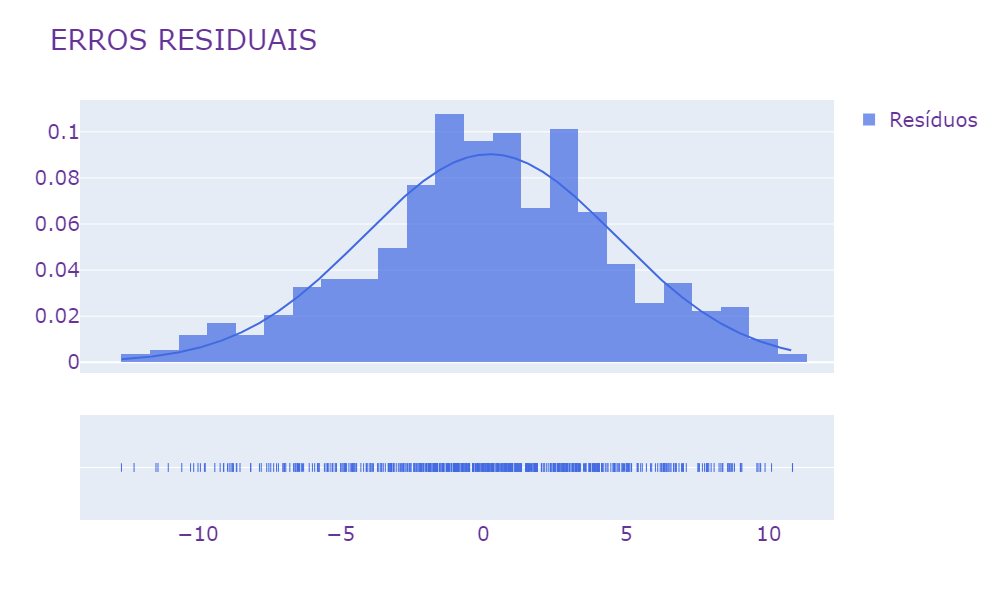

In [20]:
df_results.prediction = df_results.prediction.astype(float)
df_results.MAE = df_results.MAE.astype(float)
df_results.PAD = df_results.PAD.astype(float)


residuals = df_results.PAD
fig=ff.create_distplot([residuals], ['Resíduos'], colors=['royalblue'], curve_type='normal')

fig.update_layout(font=dict(
                       size=20,
                       color="RebeccaPurple"),title='ERROS RESIDUAIS',
                  width=900, height=600)
fig.show()

## ResNet50

In [21]:
test_data = ADNIDatasetForBraTSModel('/home/jupyter/data/ADNI/brats_2mm_preprocessed/ADNI_slices_fix_2mm_split.hdf5', dataset='test')
len(test_data) / 40

584.0

In [22]:
net = models.resnet50(pretrained=True)
net.fc = nn.Sequential(nn.Linear(2048, 1))
net = wandb_victor(net, 'victorhro/ADNI-testes/gz6krggy').to(device)
net.eval();

  0%|          | 0/584 [00:00<?, ?it/s]

Per-image MAE   = 3.9875
Per-subject MAE = 3.5730 (mean agg)
Per-subject MAE = 3.5511 (median agg)
std: 4.9560227


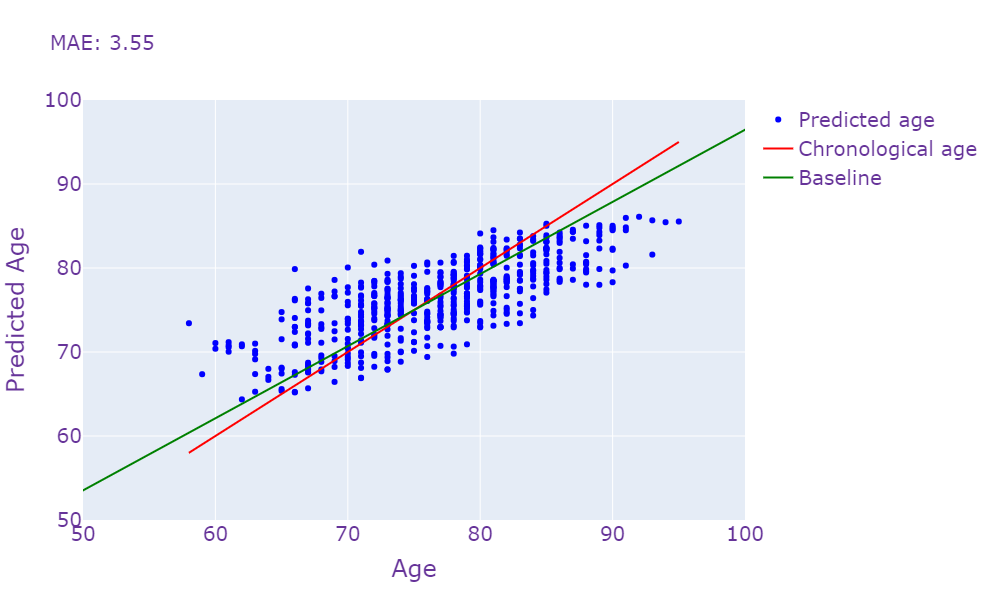

In [23]:
y, y_pred = show_predictions(test_data, net)

In [24]:
df_results = predictions_dataframe(y[:,0], np.median(y_pred,axis=-1))
save_pred(y[:,0], y_pred.mean(axis=-1), df_results, path='/home/jupyter/gama/brain-age/predictions/resnet50/split_80-20/test/')

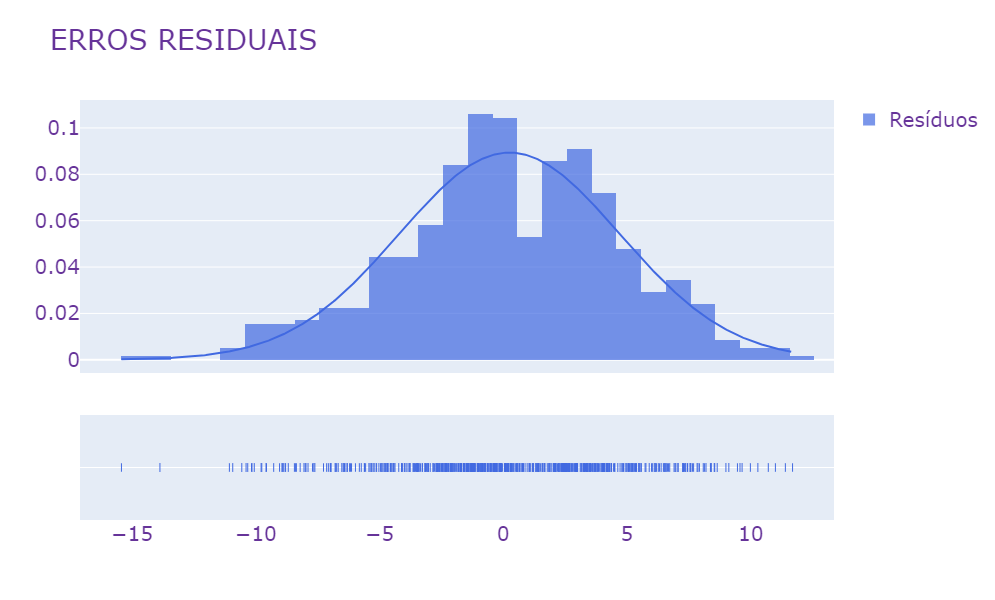

In [25]:
df_results.prediction = df_results.prediction.astype(float)
df_results.MAE = df_results.MAE.astype(float)
df_results.PAD = df_results.PAD.astype(float)


residuals = df_results.PAD
fig=ff.create_distplot([residuals], ['Resíduos'], colors=['royalblue'], curve_type='normal')

fig.update_layout(font=dict(
                       size=20,
                       color="RebeccaPurple"),title='ERROS RESIDUAIS',
                  width=900, height=600)
fig.show()

## ResNet101

In [26]:
test_data = ADNIDatasetForBraTSModel('/home/jupyter/data/ADNI/brats_2mm_preprocessed/ADNI_slices_fix_2mm_split.hdf5', dataset='test')
len(test_data) / 40

584.0

In [27]:
net = models.resnet101(pretrained=True)
net.fc = nn.Sequential(nn.Linear(2048, 1))
net = wandb_victor(net, 'victorhro/ADNI-testes/1gewglhd').to(device)  #batch 64
net.eval();

  0%|          | 0/584 [00:00<?, ?it/s]

Per-image MAE   = 4.0369
Per-subject MAE = 3.5853 (mean agg)
Per-subject MAE = 3.5774 (median agg)
std: 4.9244924


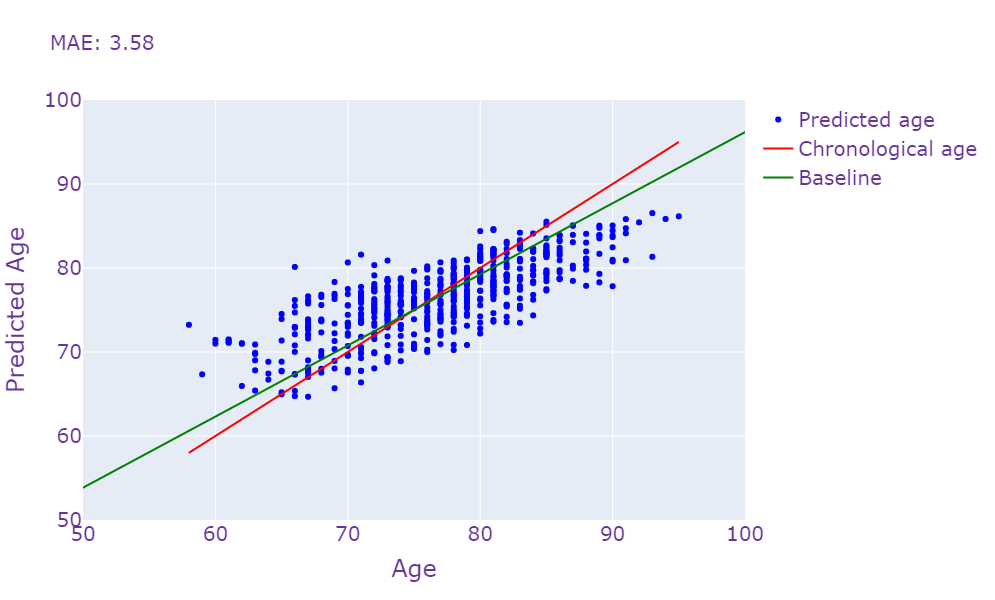

In [28]:
y, y_pred = show_predictions(test_data, net)

In [69]:
df_results = predictions_dataframe(y[:,0], np.median(y_pred,axis=-1))
save_pred(y[:,0], np.median(y_pred,axis=-1), df_results, path='/home/jupyter/gama/brain-age/predictions/resnet101/split_80-20/test/')

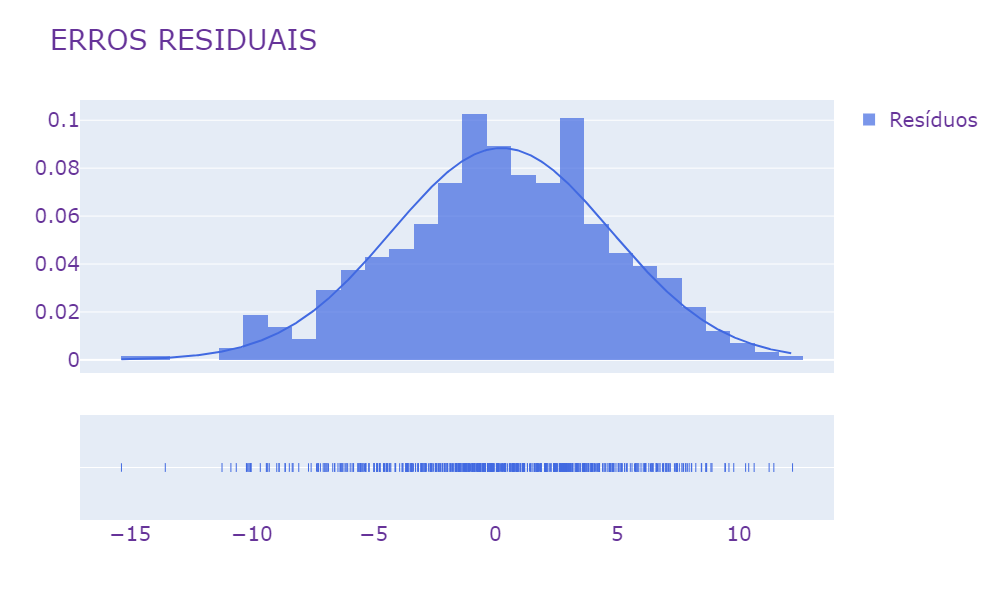

In [70]:
df_results.prediction = df_results.prediction.astype(float)
df_results.MAE = df_results.MAE.astype(float)
df_results.PAD = df_results.PAD.astype(float)


residuals = df_results.PAD
fig=ff.create_distplot([residuals], ['Resíduos'], colors=['royalblue'], curve_type='normal')

fig.update_layout(font=dict(
                       size=20,
                       color="RebeccaPurple"),title='ERROS RESIDUAIS',
                  width=900, height=600)
fig.show()

## InceptionResnetV2

In [29]:
test_data = ADNIDatasetForBraTSModel('/home/jupyter/data/ADNI/brats_2mm_preprocessed/ADNI_slices_fix_2mm_split.hdf5', dataset='test')
len(test_data) / 40

584.0

In [30]:
import timm
net = timm.create_model('inception_resnet_v2', pretrained=True)
net.classif = nn.Sequential(nn.Linear(1536, 1))
net = wandb_victor(net, 'victorhro/ADNI-testes/bw2ovvir').to(device)
net.eval();

  0%|          | 0/584 [00:00<?, ?it/s]

Per-image MAE   = 1497.0425
Per-subject MAE = 1494.0125 (mean agg)
Per-subject MAE = 3.4638 (median agg)
std: 13837.5625


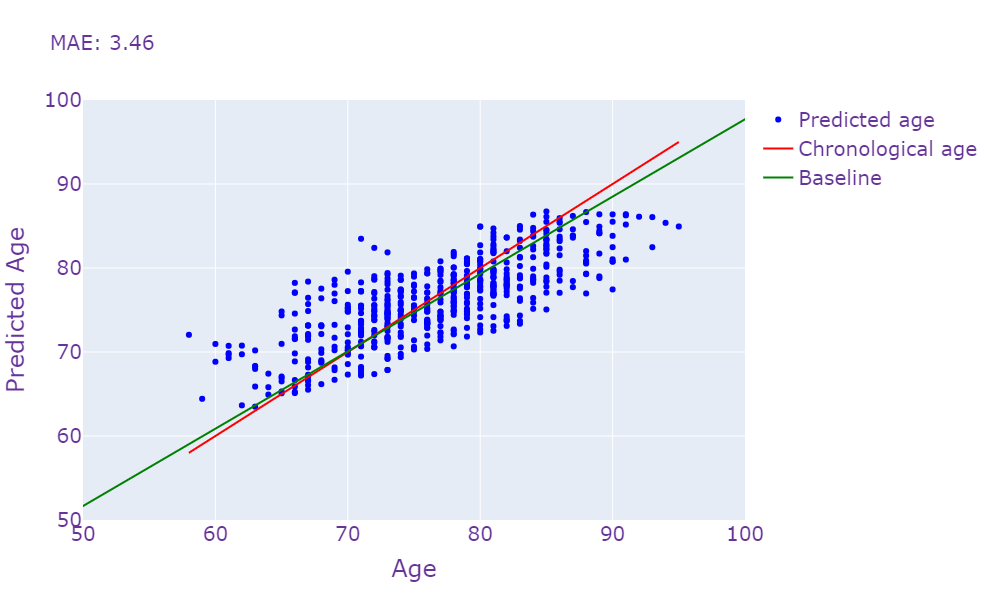

In [31]:
y, y_pred = show_predictions(test_data, net)

In [32]:
df_results = predictions_dataframe(y[:,0], np.median(y_pred,axis=-1))
save_pred(y[:,0], y_pred.mean(axis=-1), df_results, path='/home/jupyter/gama/brain-age/predictions/inception_resnet_v2/split_80-20/test/')

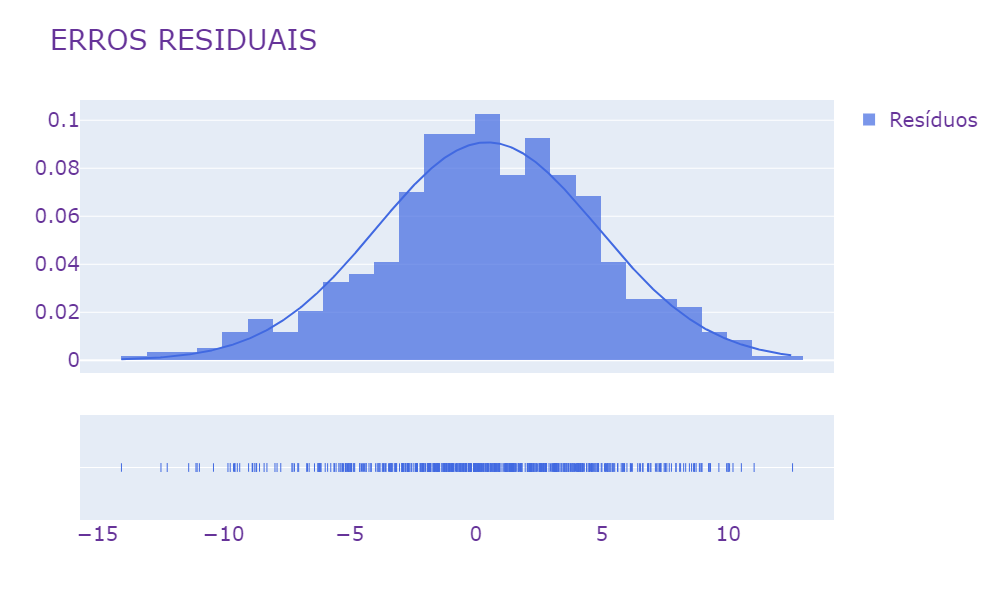

In [33]:
df_results.prediction = df_results.prediction.astype(float)
df_results.MAE = df_results.MAE.astype(float)
df_results.PAD = df_results.PAD.astype(float)


residuals = df_results.PAD
fig=ff.create_distplot([residuals], ['Resíduos'], colors=['royalblue'], curve_type='normal')

fig.update_layout(font=dict(
                       size=20,
                       color="RebeccaPurple"),title='ERROS RESIDUAIS',
                  width=900, height=600)
fig.show()

## nnUnet

In [15]:
from src.net import BraTSnnUNet
import src.net

In [16]:
test_data = ADNIDatasetForBraTSModel('/home/jupyter/data/ADNI/brats_2mm_preprocessed/ADNI_slices_fix_2mm_split.hdf5', dataset='test')
len(test_data) / 40

584.0

In [17]:
net = torch.load(PROJ_ROOT/'models/brats_model.pt')
net.pooling = nn.AvgPool2d(3)
net = wandb_gama(net, project='ADNI-brain-age', run_id='fz0yyjl2').to(device)  # pre-trained, linear lr decay
net.eval()
net;



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



  0%|          | 0/584 [00:00<?, ?it/s]

  0%|          | 0/584 [00:00<?, ?it/s]

Per-image MAE   = 3.8458
Per-subject MAE = 3.3852 (mean agg)
Per-subject MAE = 3.4019 (median agg)
std: 5.3682957


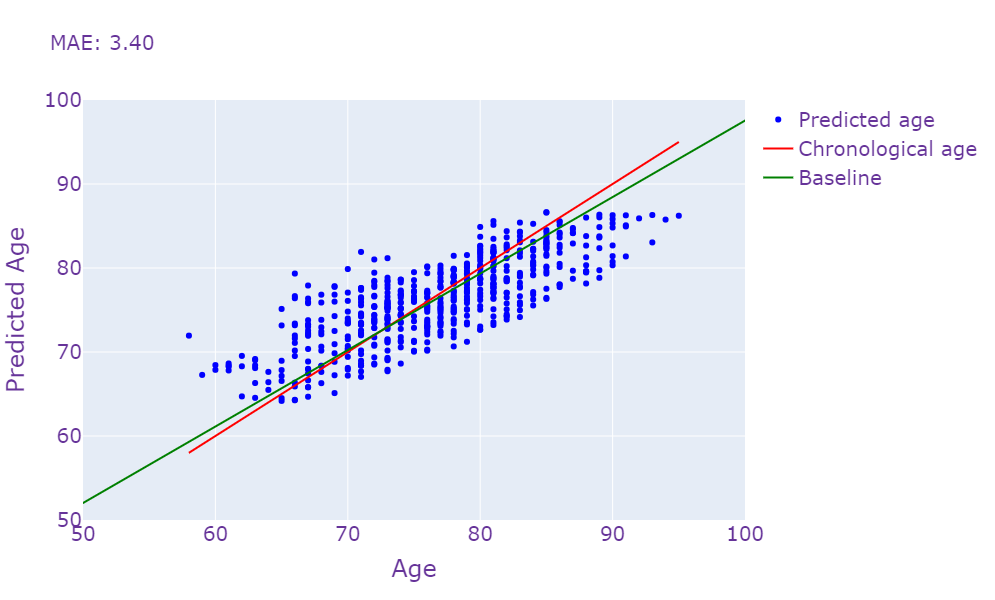

In [18]:
y, y_pred = show_predictions(test_data, net)

In [19]:
df_results = predictions_dataframe(y[:,0], np.median(y_pred,axis=-1))
save_pred(y[:,0], y_pred.mean(axis=-1), df_results, path='/home/jupyter/gama/brain-age/predictions/nnunet/split_80-20/test/')

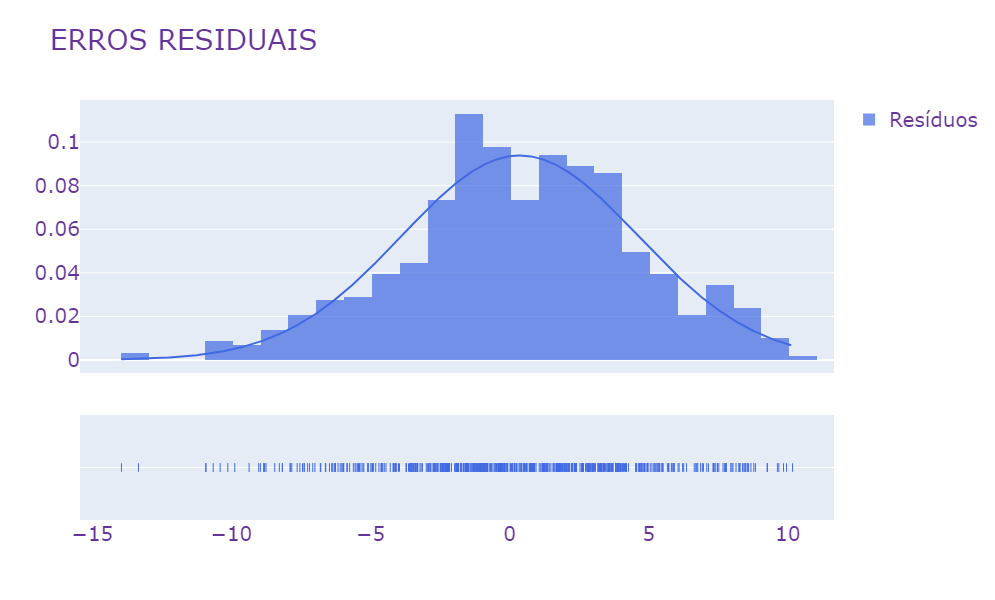

In [20]:
# fig = px.histogram(x=residuals, marginal='box', labels={'x':'resíduos', 'count': 'frequência'}, title='ERROS RESIDUAIS')

import plotly.figure_factory as ff

df_results.PAD=df_results.PAD.astype(float)
residuals = df_results.PAD
fig=ff.create_distplot([residuals], ['Resíduos'], colors=['royalblue'], curve_type='normal')

fig.update_layout(font=dict(
                       size=20,
                       color="RebeccaPurple"),title='ERROS RESIDUAIS',
                  width=900, height=600)
fig.show()